# Generating images with Huggingface Diffusers on Voyager

This Jupyter notebook shows an example of image generation using Huggingface Diffusers. To do this, we need the *optimum-habana* [(https://github.com/huggingface/optimum-habana)](https://github.com/huggingface/optimum-habana) package which is the interface between Intel Gaudi accelarators and Hugginface Diffusers (and Transformers!). In this example, we run inference on [Stable-Diffusion v1.5](https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5) although any model hosted in Huggingface could be used

In [1]:
#quick check of the Gaudi card
!hl-smi

+-----------------------------------------------------------------------------+
| HL-SMI Version:                              hl-1.15.1-fw-49.0.0.0          |
| Driver Version:                                     1.15.1-62f612b          |
|-------------------------------+----------------------+----------------------+
| AIP  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | AIP-Util  Compute M. |
|===============================+======================+======================|
|   0  HL-205              N/A  | 0000:cc:00.0     N/A |                   0  |
| N/A   35C   N/A   104W / 350W |    512MiB / 32768MiB |     0%           N/A |
|-------------------------------+----------------------+----------------------+
| Compute Processes:                                               AIP Memory |
|  AIP       PID   Type   Process name                             Usage      |
|=======================================

### Install the optimum-habana package

In [2]:
!pip install optimum-habana==1.13.1 #this version has been verified for SynapseAI 1.15.1 (currently on Voyager). Later versions may lead to incompatbilities

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.7/565.7 kB 14.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 316.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 127.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 398.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 391.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 268.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 301.1 MB/s eta 0:00:00
   ━━━━━━━━━

### Loading the package

We need to import two classes from Hugginface Diffusers: the scheduler and the pipeline.
- Scheduler: Defines the method to denoise (during inference) a given image and timestep. In this example we use DDIM
- Pipeline: High level class to generate images.

Optimum-habana has modified these two classes to run on the Intel Gaudi Cards. Those optimized classes are built on top of Hugginface Diffusers and usually start with the `Gaudi` word

In [3]:
from optimum.habana.diffusers import GaudiDDIMScheduler, GaudiStableDiffusionPipeline

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:339: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[WARNING|utils.py:212] 2025-04-08 18:59:16,644 >> optimum-habana v1.13.1 has been validated for SynapseAI v1.17.0 but habana-frameworks v1.15.1.15 was found, this could lead to undefined behavior!
[WARNING|utils.py:225] 2025-04-08 18:59:17,045 >> optimum-habana v1.13.1 has been validated for SynapseAI v1.17.0 but the driver version is v1.15.1, this could lead to undefined behavior!
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:339: UserWarning: torch.utils._pytree._register_pytree_

### Load the pretrained model

Any model from Hugginface can be used. We took as an example the Stable Diffusion v1.5. For faster execution, the model has been previously downloaded and is stored in the `/dataset` volume defined in the container.

In [4]:
model_name='/dataset/stable-diffusion-v1-5'
#model_name='/dataset/stable-diffusion-2-1-base'

### Call the scheduler

A new scheduler is created from the optimum base class `GaudiDDIMScheduler`

In [5]:
scheduler = GaudiDDIMScheduler.from_pretrained(model_name, subfolder="scheduler")

### Create the pipeline

From the optimum pipeline class, create a new pipeline. It will need as an input: model name, scheduler and some Gaudi parameters. `Gaudi_config` add extra parameters as the precision, optimizers...

In [6]:
pipeline = GaudiStableDiffusionPipeline.from_pretrained(
    model_name,
    scheduler=scheduler,
    use_habana=True,
    use_hpu_graphs=True,
    gaudi_config="Habana/stable-diffusion",
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[INFO|pipeline_utils.py:130] 2025-04-08 18:59:39,405 >> Enabled HPU graphs.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


gaudi_config.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

[INFO|configuration_utils.py:327] 2025-04-08 18:59:39,928 >> loading configuration file gaudi_config.json from cache at /root/.cache/huggingface/hub/models--Habana--stable-diffusion/snapshots/60ee357057ec90d2b183de22d0327ddd5d5a6db9/gaudi_config.json
[INFO|configuration_utils.py:380] 2025-04-08 18:59:39,929 >> GaudiConfig {
  "autocast_bf16_ops": null,
  "autocast_fp32_ops": null,
  "optimum_version": "1.24.0",
  "transformers_version": "4.43.4",
  "use_dynamic_shapes": false,
  "use_fused_adam": true,
  "use_fused_clip_norm": true,
  "use_torch_autocast": true
}

============================= HABANA PT BRIDGE CONFIGURATION =========================== 
 PT_HPU_LAZY_MODE = 1
 PT_RECIPE_CACHE_PATH = 
 PT_CACHE_FOLDER_DELETE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = 
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
---------------------------: System Configuration :---------------------------
Num CPU Cores : 96
CPU RAM      

### Inference

To generate images from the diffusion model, the pipeline needs to be executed. As arguments, give a prompt, the number of images and batch size.

In [7]:
outputs = pipeline(
    ["A panda eating a taco"],
    num_images_per_prompt=8,
    batch_size=4,
)

[INFO|pipeline_stable_diffusion.py:411] 2025-04-08 18:59:56,526 >> 1 prompt(s) received, 8 generation(s) per prompt, 4 sample(s) per batch, 2 total batch(es).
[WARNING|pipeline_stable_diffusion.py:416] 2025-04-08 18:59:56,527 >> The first two iterations are slower so it is recommended to feed more batches.


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/unets/unet_2d_blocks.py:1369: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/diffusers/models/unets/unet_2d_blocks.py:2628: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)
[INFO|pipeline_stable_diffusion.py:606] 2025-04-08 19:01:47,174 >> Speed metrics: {'generati

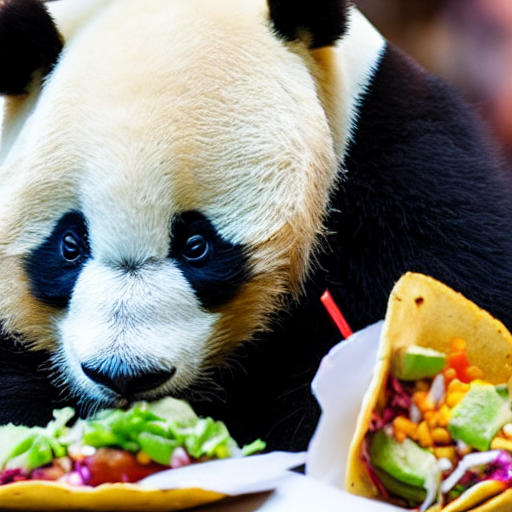

In [10]:
outputs.images[1]